In [1]:
# Generate simulation data

In [2]:
import sys
sys.path.append("./mypkg")
from constants import RES_ROOT, DATA_ROOT

In [3]:
from easydict import EasyDict as edict
import numpy as np
import numpy.random as npr
from tqdm import tqdm
from cp_predict import CPNaive, CPSimple1
from cp_predict.cp_simple1wx import CPSimple1wx
from utils.misc import save_pkl, num2str
from joblib import Parallel, delayed
from data_gen import MyDataGen
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt


In [4]:
%load_ext autoreload
%autoreload 2
# 0,1, 2, 3, be careful about the space

In [5]:
config = edict()
config.alpha = 0.10
config.ntrain = 1000
config.xysize = (2, 2)
config.can_hfcts = np.logspace(-4, 4, 15)
config.split_ratio = 0.5
config.fmodel_type = "LIN"
config.M = None
config.noise_std = 1
config.noise_type = "normal"
config.X_type = "binary"

config.verbose = 2

In [6]:
# load data to get eps 

def _gen_data(ntrain, config, seed):
    A = npr.randn(*config.xysize).T;
    A = (A + A.T)/2
    datagen = MyDataGen(xysize=config.xysize, 
                        A=A, 
                        X_type=config.X_type, 
                        noise_type=config.noise_type, 
                        noise_std=config.noise_std)
    np.random.seed(seed)
    seeds = npr.randint(0, 1000000, 2)    
    Xtrain, Ytrain = datagen(n=ntrain, seed=seeds[0])
    Xtest, Ytest = datagen(n=10000, seed=seeds[1])
    return Xtrain, Ytrain, Xtest, Ytest

def _get_model(typ="SVR"):
    if typ == "SVR":
        model =  SVR(kernel="rbf")
    elif typ == "MLP":
        model = MLPRegressor(hidden_layer_sizes=(100,), max_iter=1000)
    elif typ == "LIN": 
        model = LinearRegression()
    
    if config.xysize[1] > 1:
        model = MultiOutputRegressor(model)
    return model

In [7]:
seed = 0
Xtrain, Ytrain, Xtest, Ytest = _gen_data(config.ntrain, config, seed)
fmodel = _get_model(typ=config.fmodel_type)
fmodel.fit(Xtrain, Ytrain); 

cur_ys_train, cur_fs_train = Ytrain, fmodel.predict(Xtrain)
cur_ys_test, cur_fs_test = Ytest, fmodel.predict(Xtest)

In [8]:
cpfit = CPSimple1wx(
    cur_ys_train, cur_fs_train, Xtrain,
                 kernel_fn=CPSimple1wx.bump_kerfn,
                 M=None,
                 verbose=config.verbose)

In [9]:
cpfit.M

array([0.99859089, 0.99748253])

array([1.70851991e-01, 1.94019764e-05, 1.70870000e-01])

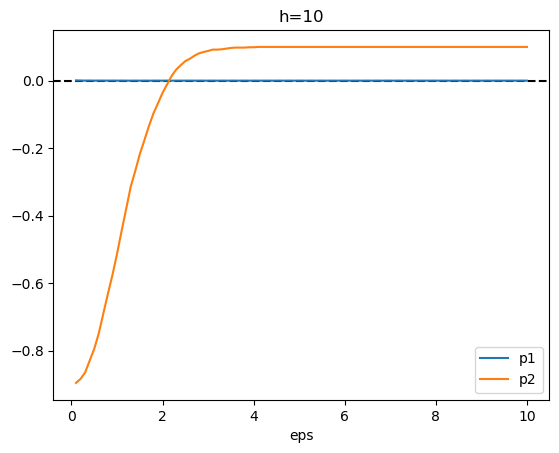

In [10]:
epss = np.linspace(0.1, 10, 100)
h = 10
vs = []
for eps in epss:
    v = cpfit._phi_fn_diff1(eps=eps, alpha=config.alpha, h=h)
    vs.append(v)
vs = np.array(vs);

plt.axhline(0, color="black", linestyle="--")
plt.plot(epss, vs[:, 1], label="p1")
plt.plot(epss, vs[:, 2], label="p2")
plt.legend()
plt.title(f"h={h}")
plt.xlabel("eps")
#plt.xscale("log")
np.abs(vs).mean(axis=0)

In [11]:
hs = np.logspace(-5, 3, 100)
epss = []
covprobs = []
for h in tqdm(hs):
    cpfit.fit(alpha=config.alpha, h=h, opt_params={"bds": (0.01, 1000)})
    Rs_test, in_sets = cpfit.predict(cur_fs_test, cur_ys_test);
    epss.append(cpfit.eps)
    covprobs.append(in_sets.mean())

 40%|██████████████████████████████                                             | 40/100 [00:00<00:01, 44.51it/s]/data/rajlab1/user_data/jin/MyResearch/imageCP_dev/./mypkg/cp_predict/cp_base.py:104: RuntimeWarning: overflow encountered in exp
  y = np.exp(-h**2/(h**2-x**2))
100%|██████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 47.28it/s]


Text(0.5, 1.0, 'Coverage vs h')

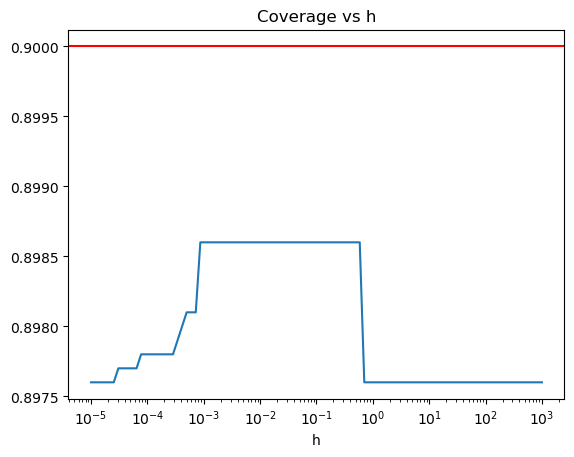

In [14]:
plt.plot(hs[:], covprobs)
plt.axhline(y=1-config.alpha, color="red")
plt.xlabel("h")
plt.xscale("log")
plt.title("Coverage vs h")

Text(0.5, 1.0, 'eps vs h')

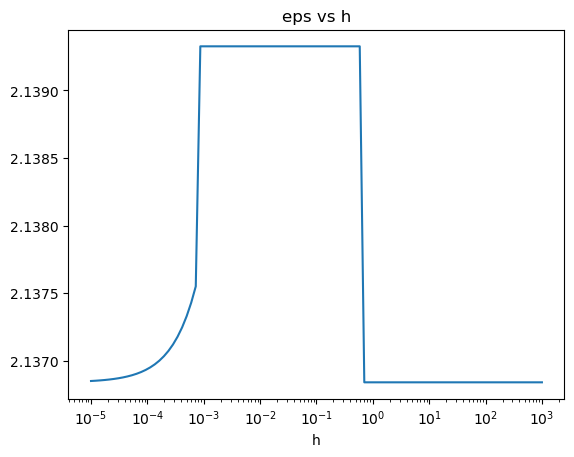

In [15]:
plt.plot(hs[:], epss)
plt.xlabel("h")
plt.xscale("log")
plt.title("eps vs h")